# Pancreas endocrinogenesis E1415 - scVelo

# Imports and settings

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scvelo as scv
import cellrank as cr
import anndata as ad
from cellrank.kernels import ConnectivityKernel, VelocityKernel
from cellrank.estimators import GPCCA

In [2]:
cr.logging.print_versions()

cellrank==1.5.1+g525b847 scanpy==1.9.1 anndata==0.8.0 numpy==1.23.5 numba==0.56.4 scipy==1.10.0 pandas==1.5.2 pygpcca==1.0.4 scikit-learn==1.2.0 statsmodels==0.13.5 scvelo==0.2.5 pygam==0.8.0 matplotlib==3.6.2 seaborn==0.12.2


# Data loading and preprocessing

In [ ]:
adata145 = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/pancreas/day_14.5_growth_rate.h5ad")
adata155 = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/pancreas/day_15.5_growth_rate.h5ad")
adata = ad.concat([adata145, adata155])

adata.obsp = {}
adata.uns = {}
adata.obsm = {}
adata.varm = {}
adata.obs = adata.obs.loc[:, ['day', 'celltype']]
adata.var = adata.var[[]]

adata

In [ ]:
adata_fourteen = adata[adata.obs['day'] == 14.5, :].copy()
adata_fiveteen = adata[adata.obs['day'] == 15.5, :].copy()

In [ ]:
scv.pp.pca(adata_fourteen, n_comps=50)
scv.pp.moments(adata_fourteen)
scv.tl.recover_dynamics(adata_fourteen, n_jobs=10)
scv.tl.velocity(adata_fourteen, mode='dynamical')

In [ ]:
scv.pp.pca(adata_fiveteen, n_comps=50)
scv.pp.moments(adata_fiveteen)
scv.tl.recover_dynamics(adata_fiveteen, n_jobs=10)
scv.tl.velocity(adata_fiveteen, mode='dynamical')

In [ ]:
adata = ad.concat([adata_fourteen, adata_fiveteen])
sc.pp.neighbors(old_adata)
scv.tl.umap(adata)

# Precomputed data

In [3]:
adata = sc.read("/home/icb/jonas.flor/precomputed_data/scvelo_pan_pre.h5ad")

# Transition probabilities

In [4]:
vk = VelocityKernel(adata).compute_transition_matrix()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20519/20519 [00:21<00:00, 964.55cell/s]


# Macrostate calculation

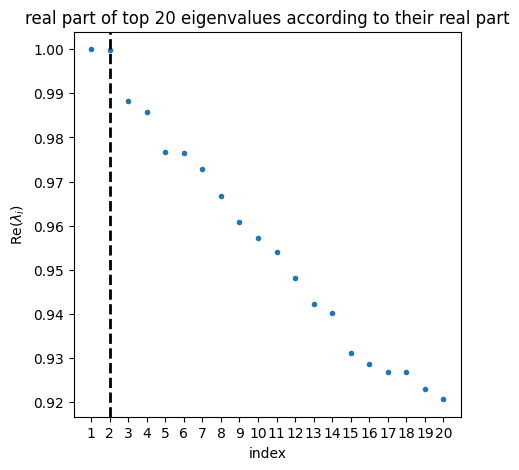

In [5]:
g = GPCCA(vk)
g.compute_schur(n_components=20)
g.plot_spectrum(real_only=True)

/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


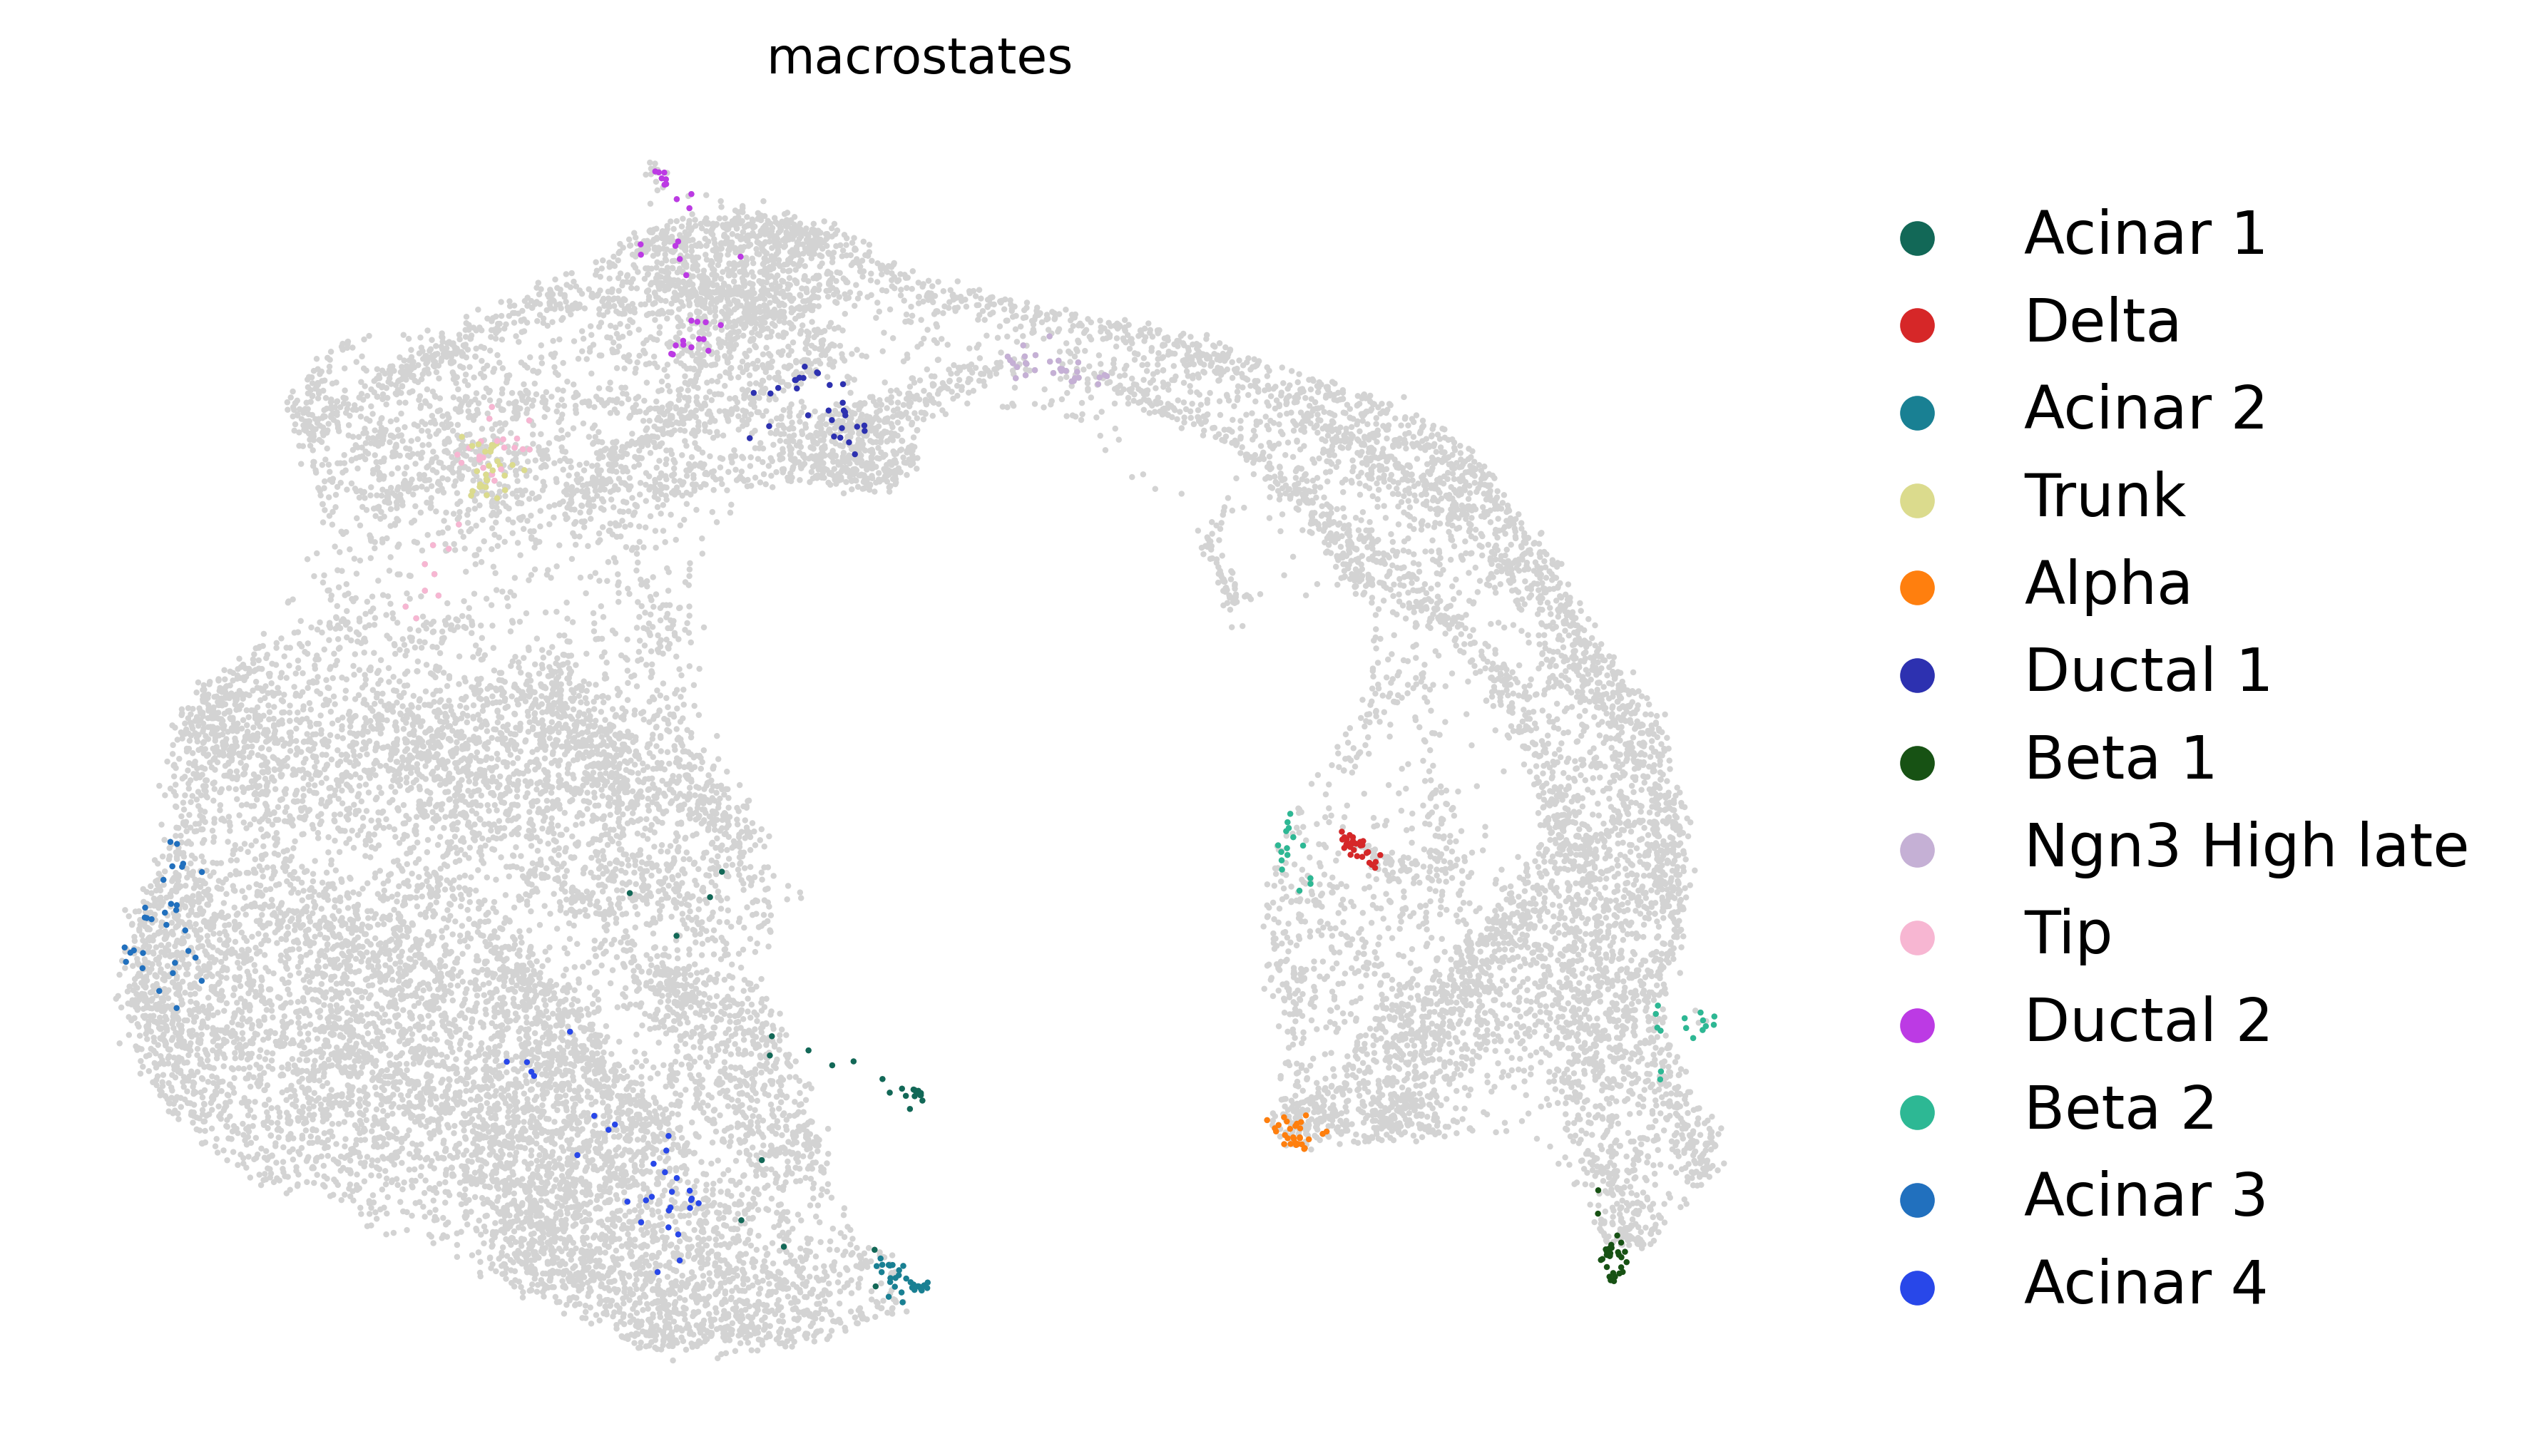

In [6]:
g.compute_macrostates(n_states=13, cluster_key="celltype")
scv.set_figure_params('scvel o', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

In [ ]:
g.compute_macrostates(n_states=14, cluster_key="celltype")
scv.set_figure_params('scvel o', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

# Fate probabilities

In [ ]:
g.set_terminal_states_from_macrostates(
    [
        "Acinar_1", "Acinar_2", "Acinar_3", "Acinar_4", "Ductal_1", "Ductal_2", "Ductal_3","Alpha", "Beta", "Delta", "Epsilon" 
    ]
)
g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu')
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=2)

In [ ]:
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
cr.pl.aggregate_absorption_probabilities(
    adata,
    mode='heatmap',
    lineages=["Acinar_1", "Acinar_2", "Acinar_3", "Acinar_4", "Ductal_1", "Ductal_2", "Ductal_3","Alpha",
              "Beta", "Delta", "Epsilon" ],
    cluster_key='celltype',
    clusters=['Acinar', 'Multipotent', 'Tip', 'Ductal', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Alpha', 
              'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 6),
    title="",
    #save="transprobs_pancreas1415_scvelo.png"
)

In [ ]:
cluster = ['Acinar', 'Multipotent', 'Tip', 'Ductal', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon']
terminal_cluster = ["Acinar_1", "Acinar_2", "Acinar_3", "Acinar_4", "Ductal_1", "Ductal_2", "Ductal_3","Alpha", "Beta", "Delta", "Epsilon"]

aggregated_absorption_prob = np.empty((len(terminal_cluster), len(cluster)))
data = g.absorption_probabilities.X
sums = np.sum(data, axis=0)
tmp = adata.obs['celltype']

for i in range(len(cluster)):
    aggregated_absorption_prob[:,i] = np.dot(np.array((tmp.array==cluster[i]).astype(int)),data)
for i in range(len(cluster)):
    aggregated_absorption_prob[:,i] = aggregated_absorption_prob[:,i]/np.sum(aggregated_absorption_prob[:,i])
df = pd.DataFrame(aggregated_absorption_prob)
df.index = terminal_cluster
df.columns = cluster

In [ ]:
correct_transitions = [('Acinar_1', 'Acinar'), ('Acinar_2', 'Acinar'), ('Acinar_3', 'Acinar'), 
                       ('Acinar_4', 'Acinar'), ('Acinar_1', 'Tip'), ('Acinar_2', 'Tip'), ('Acinar_3', 'Tip'), 
                       ('Acinar_4', 'Tip'), ('Acinar_1', 'Multipotent'), ('Acinar_2', 'Multipotent'),
                       ('Acinar_3', 'Multipotent'), ('Acinar_4', 'Multipotent'),
                       ('Ductal_1', 'Ductal'), ('Ductal_2', 'Ductal'), ('Ductal_3', 'Ductal'),
                       ('Ductal_1', 'Multipotent'), ('Ductal_2', 'Multipotent'), ('Ductal_3', 'Multipotent'),
                       ('Alpha', 'Alpha'), ('Alpha', 'Fev+ Beta'), ('Alpha', 'Fev+ Delta'),
                       ('Alpha', 'Fev+ Alpha'), ('Alpha', 'Fev+ Epsilon'), ('Alpha', 'Ngn3 High early'),
                       ('Alpha', 'Ngn3 High late'), ('Beta', 'Beta'), ('Beta', 'Fev+ Beta'), ('Beta', 'Fev+ Delta'),
                       ('Beta', 'Fev+ Alpha'), ('Beta', 'Fev+ Epsilon'), ('Beta', 'Ngn3 High early'), 
                       ('Beta', 'Ngn3 High late'), ('Delta', 'Delta'), ('Delta', 'Fev+ Beta'), 
                       ('Delta', 'Fev+ Delta'), ('Delta', 'Fev+ Alpha'), ('Delta', 'Fev+ Epsilon'),
                       ('Delta', 'Ngn3 High early'), ('Delta', 'Ngn3 High late'), ('Epsilon', 'Epsilon'), 
                       ('Epsilon', 'Fev+ Beta'), ('Epsilon', 'Fev+ Delta'), ('Epsilon', 'Fev+ Alpha'), 
                       ('Epsilon', 'Fev+ Epsilon'), ('Epsilon', 'Ngn3 High early'), ('Epsilon', 'Ngn3 High late'), 
                       ('Alpha', 'Multipotent'),('Epsilon', 'Multipotent'), ('Beta', 'Multipotent'), 
                       ('Delta', 'Multipotent')]

sum_prob = 0
for i in correct_transitions:
    sum_prob = sum_prob + df.loc[i]
mean_prob = sum_prob/len(cluster)
mean_prob

# Velocity stream plot

In [ ]:
adata.uns["velocity_graph"] = vk.transition_matrix

scv.set_figure_params('scvelo', transparent=True, fontsize=10, dpi_save=400,color_map='viridis')
fig = plt.figure()
ax = scv.pl.velocity_embedding_stream(adata, basis="umap", smooth=0.5, title="", legend_loc="none", show=False)
legend =ax.legend(bbox_to_anchor=[1.25, 1.5], loc='upper center', ncol=6,frameon=True, prop={'size': 18})
#plt.savefig("velstream_pancreas1415_scvelo", dpi=800, bbox_inches='tight')

In [ ]:
scv.tl.velocity_confidence(adata)

In [ ]:
scv.set_figure_params('scvelo', fontsize=20)
scv.settings.presenter_view = False
scv.pl.scatter(adata, color='velocity_confidence',
               perc=[2, 98],
               cmap='gnuplot',
               vmid=0.75,
               rescale_color=[0.5, 1.0],
               size=15,
               title="",
               #save="velconf_pancreas1415_scvelo.png"
              )